In [8]:
import numpy as np
import random
import time
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForest
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, recall_score, f1_score

In [9]:
def custom_accuracy(y_true, y_pred):
    """
    Υπολογίζει την ακρίβεια του μοντέλου.
    """
    correct = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
    return correct / len(y_true)

In [10]:
class Node:
    """
    Αναπαριστά έναν κόμβο σε ένα ID3 δέντρο απόφασης.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [11]:
class ID3DecisionTree:
    """
    Ένα ID3 Decision Tree για ταξινόμηση δυαδικών δεδομένων.
    """
    def __init__(self, max_depth=10, min_samples_split=3, max_features='sqrt'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None
    
    def fit(self, X, y):
        self.root = self._grow_tree(X, y)
    def _grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(set(y))
        
        if num_labels == 1 or num_samples < self.min_samples_split:
            return Node(value=Counter(y).most_common(1)[0][0])
        
        if self.max_depth and depth >= self.max_depth:
            return Node(value=Counter(y).most_common(1)[0][0])
        
        best_feature, best_threshold = self._best_split(X, y, num_features)
        
        if best_feature is None:
            return Node(value=Counter(y).most_common(1)[0][0])
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        left = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)
    
    def _best_split(self, X, y, num_features):
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        feature_indices = np.random.choice(num_features, max(1, int(np.sqrt(num_features))), replace=False)
        for feature in feature_indices:
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                gain = self._information_gain(X, y, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _information_gain(self, X, y, feature, threshold):
        parent_entropy = self._entropy(y)
        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold
        
        if sum(left_indices) == 0 or sum(right_indices) == 0:
            return 0
        
        left_entropy = self._entropy(y[left_indices])
        right_entropy = self._entropy(y[right_indices])
        
        n, n_left, n_right = len(y), sum(left_indices), sum(right_indices)
        child_entropy = (n_left / n) * left_entropy + (n_right / n) * right_entropy
        return parent_entropy - child_entropy
    
    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [12]:
class RandomForest:
    """
    Υλοποιεί τον αλγόριθμο Random Forest χρησιμοποιώντας ID3 Decision Trees.
    """
    def __init__(self, n_trees=100, max_depth=10, min_samples_split=3, max_samples=0.8, random_state=42):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_samples = max_samples
        self.random_state = random_state
        self.trees = []
    def fit(self, X, y):
        self.trees = []
        np.random.seed(self.random_state)
        num_samples = int(len(X) * self.max_samples)
        for _ in range(self.n_trees):
            indices = np.random.choice(len(X), num_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = ID3DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.array([Counter(tree_preds[:, i]).most_common(1)[0][0] for i in range(X.shape[0])])

In [13]:
# Φόρτωση και προεπεξεργασία IMDB dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)
tokenizer = Tokenizer(num_words=5000)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')

# Δημιουργία και εκπαίδευση του Custom Random Forest
custom_rf = RandomForest(n_trees=50, max_depth=10, min_samples_split=3)
start_time = time.time()
custom_rf.fit(x_train[:3000], y_train[:3000])
custom_train_time = time.time() - start_time

# Πρόβλεψη και αξιολόγηση του Custom Random Forest
start_time = time.time()
y_pred_custom = custom_rf.predict(x_test[:500])
custom_predict_time = time.time() - start_time

# Υπερπαράμετροι και τρόπος επιλογής τους
k = 5  # Αγνοούμε τις 5 πιο σπάνιες λέξεις
n = 10  # Αγνοούμε τις 10 πιο συχνές λέξεις
m = 1000  # Μέγεθος λεξιλογίου: 1000 λέξεις με το υψηλότερο πληροφοριακό κέρδος
n_trees = 50  # Πλήθος δέντρων στο Τυχαίο Δάσος
max_depth = 10  # Μέγιστο βάθος δέντρων
min_samples_split = 3  # Ελάχιστος αριθμός δειγμάτων για διαχωρισμό κόμβου
max_samples = 0.8  # Ποσοστό των δεδομένων που χρησιμοποιούνται για κάθε δέντρο
random_state = 42  # Τυχαίος seed

# Εκτύπωση των υπερπαραμέτρων
print("Υπερπαράμετροι:")
print(f"k = {k}, n = {n}, m = {m}, n_trees = {n_trees}, max_depth = {max_depth}, min_samples_split = {min_samples_split}, max_samples = {max_samples}, random_state = {random_state}")

print("\nCustom Random Forest Results:")
print("Class 0: Precision:", precision_score(y_test[:500], y_pred_custom, pos_label=0), 
      "Recall:", recall_score(y_test[:500], y_pred_custom, pos_label=0), 
      "F1:", f1_score(y_test[:500], y_pred_custom, pos_label=0))
print("Class 1: Precision:", precision_score(y_test[:500], y_pred_custom, pos_label=1), 
      "Recall:", recall_score(y_test[:500], y_pred_custom, pos_label=1), 
      "F1:", f1_score(y_test[:500], y_pred_custom, pos_label=1))
micro_precision_custom = precision_score(y_test[:500], y_pred_custom, average='micro')
micro_recall_custom = recall_score(y_test[:500], y_pred_custom, average='micro')
micro_f1_custom = f1_score(y_test[:500], y_pred_custom, average='micro')

macro_precision_custom = precision_score(y_test[:500], y_pred_custom, average='macro')
macro_recall_custom = recall_score(y_test[:500], y_pred_custom, average='macro')
macro_f1_custom = f1_score(y_test[:500], y_pred_custom, average='macro')

print("Custom Micro Average: Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(micro_precision_custom, micro_recall_custom, micro_f1_custom))
print("Custom Macro Average: Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(macro_precision_custom, macro_recall_custom, macro_f1_custom))
print("Custom Training Time: {:.2f} seconds".format(custom_train_time))
print("Custom Prediction Time: {:.2f} seconds".format(custom_predict_time))

# Δημιουργία και εκπαίδευση του Scikit-learn Random Forest
sklearn_rf = SklearnRandomForest(n_estimators=50, max_depth=10, min_samples_split=3, random_state=42)
start_time = time.time()
sklearn_rf.fit(x_train[:3000], y_train[:3000])
sklearn_train_time = time.time() - start_time

# Πρόβλεψη και αξιολόγηση του Scikit-learn Random Forest
start_time = time.time()
y_pred_sklearn = sklearn_rf.predict(x_test[:500])
sklearn_predict_time = time.time() - start_time

print("\nScikit-learn Random Forest Results:")
print("Class 0: Precision:", precision_score(y_test[:500], y_pred_sklearn, pos_label=0), 
      "Recall:", recall_score(y_test[:500], y_pred_sklearn, pos_label=0), 
      "F1:", f1_score(y_test[:500], y_pred_sklearn, pos_label=0))
print("Class 1: Precision:", precision_score(y_test[:500], y_pred_sklearn, pos_label=1), 
      "Recall:", recall_score(y_test[:500], y_pred_sklearn, pos_label=1), 
      "F1:", f1_score(y_test[:500], y_pred_sklearn, pos_label=1))

micro_precision_sklearn = precision_score(y_test[:500], y_pred_sklearn, average='micro')
micro_recall_sklearn = recall_score(y_test[:500], y_pred_sklearn, average='micro')
micro_f1_sklearn = f1_score(y_test[:500], y_pred_sklearn, average='micro')

macro_precision_sklearn = precision_score(y_test[:500], y_pred_sklearn, average='macro')
macro_recall_sklearn = recall_score(y_test[:500], y_pred_sklearn, average='macro')
macro_f1_sklearn = f1_score(y_test[:500], y_pred_sklearn, average='macro')

print("Scikit-learn Micro Average: Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(micro_precision_sklearn, micro_recall_sklearn, micro_f1_sklearn))
print("Scikit-learn Macro Average: Precision: {:.3f}, Recall: {:.3f}, F1: {:.3f}".format(macro_precision_sklearn, macro_recall_sklearn, macro_f1_sklearn))
print("Scikit-learn Training Time: {:.2f} seconds".format(sklearn_train_time))
print("Scikit-learn Prediction Time: {:.2f} seconds".format(sklearn_predict_time))

Υπερπαράμετροι:
k = 5, n = 10, m = 1000, n_trees = 50, max_depth = 10, min_samples_split = 3, max_samples = 0.8, random_state = 42

Custom Random Forest Results:
Class 0: Precision: 0.9178082191780822 Recall: 0.5114503816793893 F1: 0.6568627450980392
Class 1: Precision: 0.6384180790960452 Recall: 0.9495798319327731 F1: 0.7635135135135135
Custom Micro Average: Precision: 0.720, Recall: 0.720, F1: 0.720
Custom Macro Average: Precision: 0.778, Recall: 0.731, F1: 0.710
Custom Training Time: 224.47 seconds
Custom Prediction Time: 0.25 seconds

Scikit-learn Random Forest Results:
Class 0: Precision: 0.8894009216589862 Recall: 0.7366412213740458 F1: 0.8058455114822547
Class 1: Precision: 0.7561837455830389 Recall: 0.8991596638655462 F1: 0.8214971209213052
Scikit-learn Micro Average: Precision: 0.814, Recall: 0.814, F1: 0.814
Scikit-learn Macro Average: Precision: 0.823, Recall: 0.818, F1: 0.814
Scikit-learn Training Time: 2.93 seconds
Scikit-learn Prediction Time: 0.03 seconds


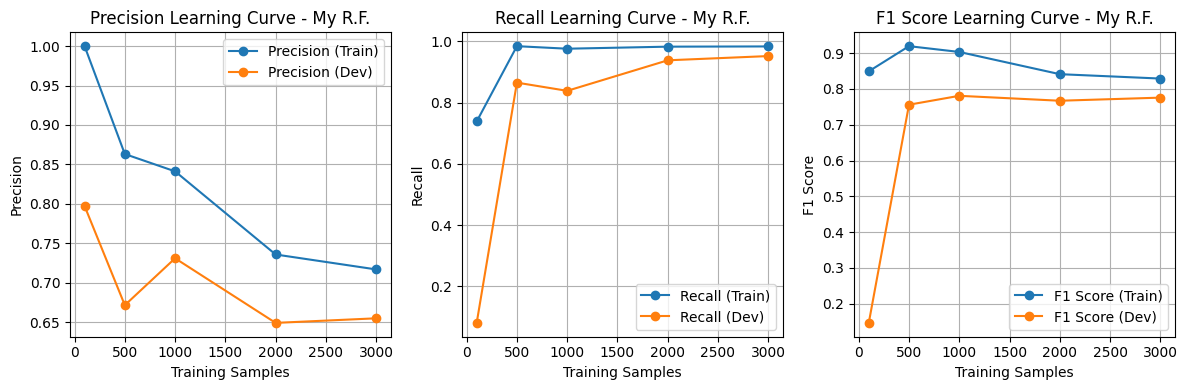

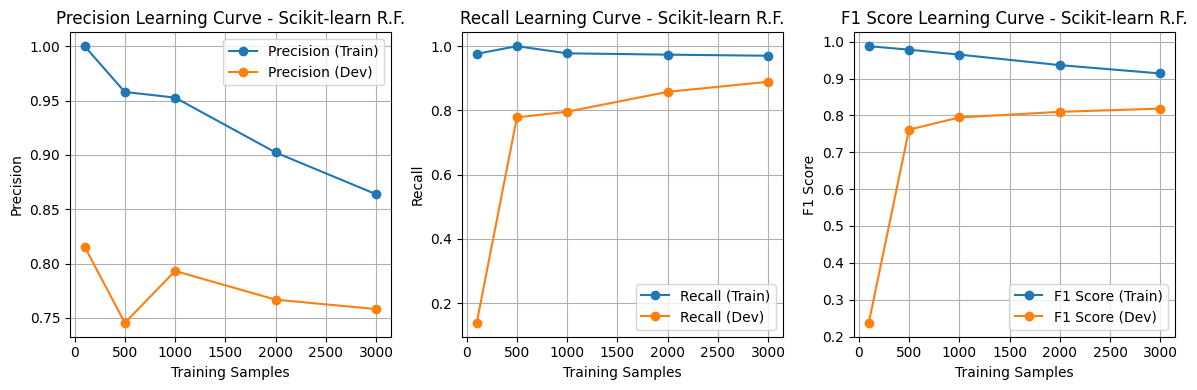

In [14]:
def calculate_metrics(model, X_train, y_train, X_test, y_test):
    """
    Υπολογίζει τα precision, recall και F1-score για ένα μοντέλο.
    """
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    return precision, recall, f1
# Καμπύλες μάθησης
def plot_learning_curves(model, X_train, y_train, X_test, y_test, train_sizes, model_name):
    precision_train, recall_train, f1_train = [], [], []
    precision_dev, recall_dev, f1_dev = [], [], []
    
    for size in train_sizes:
        model.fit(X_train[:size], y_train[:size])
        
        # Calculate metrics on the training subset
        prec_train, rec_train, f1_tr = calculate_metrics(model, X_train[:size], y_train[:size], X_train[:size], y_train[:size])
        precision_train.append(prec_train)
        recall_train.append(rec_train)
        f1_train.append(f1_tr)
        # Calculate metrics on the test data
        prec_dev, rec_dev, f1_dv = calculate_metrics(model, X_train[:size], y_train[:size], X_test, y_test)
        precision_dev.append(prec_dev)
        recall_dev.append(rec_dev)
        f1_dev.append(f1_dv)

        # Plot the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_sizes, precision_train, marker='o', label="Precision (Train)")
    plt.plot(train_sizes, precision_dev, marker='o', label="Precision (Dev)")
    plt.xlabel("Training Samples")
    plt.ylabel("Precision")
    plt.title(f"Precision Learning Curve - {model_name}")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(train_sizes, recall_train, marker='o', label="Recall (Train)")
    plt.plot(train_sizes, recall_dev, marker='o', label="Recall (Dev)")
    plt.xlabel("Training Samples")
    plt.ylabel("Recall")
    plt.title(f"Recall Learning Curve - {model_name}")
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(train_sizes, f1_train, marker='o', label="F1 Score (Train)")
    plt.plot(train_sizes, f1_dev, marker='o', label="F1 Score (Dev)")
    plt.xlabel("Training Samples")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score Learning Curve - {model_name}")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Define training sample sizes
train_sizes = [100, 500, 1000, 2000, 3000]

# Plot learning curves for custom Random Forest
plot_learning_curves(custom_rf, x_train, y_train, x_test, y_test, train_sizes, "My R.F.")

# Plot learning curves for scikit-learn Random Forest
plot_learning_curves(sklearn_rf, x_train, y_train, x_test, y_test, train_sizes, "Scikit-learn R.F.")